In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp
from os import listdir
from os.path import isfile, join
import pkg_resources
import torch 
import pandas as pd
import scipy
import torch
from  torch_geometric.datasets import TUDataset
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, download_url, Data
from pytictoc import TicToc

print("CUDA available? ", torch.cuda.is_available())
print("Backends enabled? ", torch.backends.cudnn.enabled)
print("Device count: ", torch.cuda.device_count())
print("Current device: ", torch.cuda.current_device())
device = torch.cuda.current_device()
torch.cuda.set_device(device)
print("Device name: ", torch.cuda.get_device_name(device))

#Acquire benchmark dataset 'MUTAG'
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Graphs: {len(dataset)}')
print(f'Features: {dataset.num_features}')
print(f'Classes: {dataset.num_classes}')

#Identify first graph 
data = dataset[0]

print()
print(data)
print('=============================================================')

#Statistics for  first graph
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

CUDA available?  True
Backends enabled?  True
Device count:  1
Current device:  0
Device name:  NVIDIA A40

Dataset: MUTAG(188):
Graphs: 188
Features: 7
Classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [24]:
dataset = dataset.shuffle()

#Split data into training/test 80:20
reduce = int(len(dataset))
train = round(.8 * reduce)
train_dataset = dataset[0:train]
test_dataset = dataset[train::]

print(f'Training graphs: {len(train_dataset)}')
print(f'Test graphs: {len(test_dataset)}')

Training graphs: 150
Test graphs: 38


In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#batch graphs
for step, data in enumerate(train_loader):
    print('Step ', str(step + 1))
    print('=======')
    print('Number of graphs in the current batch: ', str(data.num_graphs))
    print(data)
    print()

Step  1
Number of graphs in the current batch:  32
DataBatch(edge_index=[2, 1398], x=[624, 7], edge_attr=[1398, 4], y=[32], batch=[624], ptr=[33])

Step  2
Number of graphs in the current batch:  32
DataBatch(edge_index=[2, 1230], x=[561, 7], edge_attr=[1230, 4], y=[32], batch=[561], ptr=[33])

Step  3
Number of graphs in the current batch:  32
DataBatch(edge_index=[2, 1324], x=[596, 7], edge_attr=[1324, 4], y=[32], batch=[596], ptr=[33])

Step  4
Number of graphs in the current batch:  32
DataBatch(edge_index=[2, 1220], x=[555, 7], edge_attr=[1220, 4], y=[32], batch=[555], ptr=[33])

Step  5
Number of graphs in the current batch:  22
DataBatch(edge_index=[2, 764], x=[355, 7], edge_attr=[764, 4], y=[22], batch=[355], ptr=[23])



Epoch: 249, Train Acc: 0.9, Test Acc: 0.921


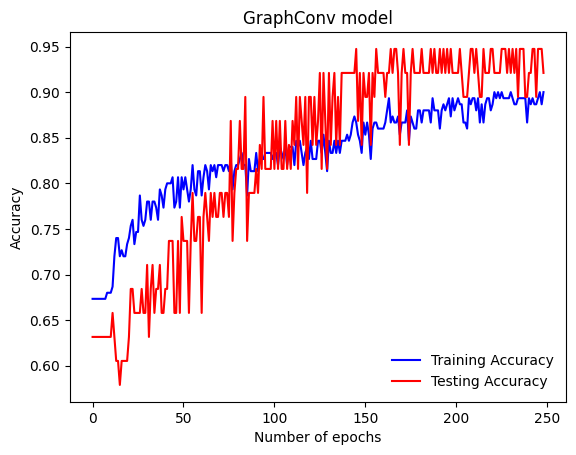

In [26]:
from GNN_functions import *
from GNN_classes import *

torch.cuda.empty_cache()

#select model class, optimizer, and criterion 
model = GConv(hidden_channels=32, dataset=dataset)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

#train and evaluate the model for some number of epochs
train_acc_ev=[]
test_acc_ev = []
epoch_ev = []

for epoch in range(1, 250):
    train(model, train_loader, device, criterion, optimizer)
    train_acc = test(model, train_loader, device)
    test_acc = test(model, test_loader, device)
    train_acc_ev.append(train_acc)
    test_acc_ev.append(test_acc)
    epoch_ev.append(epoch)

print('Epoch: ' + str(epoch) + ", Train Acc: " + str(round(train_acc,3)) + ", Test Acc: " + str(round(test_acc, 3)))

#plot accuracy as a function of epoch
plt.plot(train_acc_ev, 'b', label = 'Training Accuracy')
plt.plot(test_acc_ev, 'r', label = 'Testing Accuracy')
plt.legend(loc="lower right", frameon=False)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("GraphConv model")
plt.show()

Epoch: 249, Train Acc: 0.793, Test Acc: 0.763


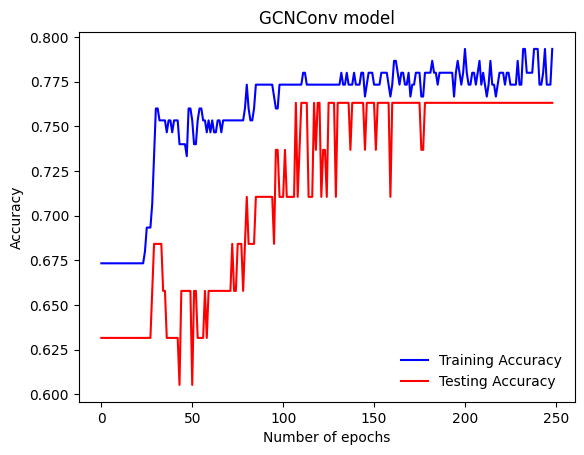

In [27]:
torch.cuda.empty_cache()

#select model class, optimizer, and criterion 
model = GCN(hidden_channels=32, dataset=dataset)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

#train and evaluate the model for some number of epochs

train_acc_ev=[]
test_acc_ev = []
epoch_ev = []

for epoch in range(1, 250):
    train(model, train_loader, device, criterion, optimizer)
    train_acc = test(model, train_loader, device)
    test_acc = test(model, test_loader, device)
    train_acc_ev.append(train_acc)
    test_acc_ev.append(test_acc)
    epoch_ev.append(epoch)

print('Epoch: ' + str(epoch) + ", Train Acc: " + str(round(train_acc,3)) + ", Test Acc: " + str(round(test_acc, 3)))

#plot accuracy as a function of epoch
plt.plot(train_acc_ev, 'b', label = 'Training Accuracy')
plt.plot(test_acc_ev, 'r', label = 'Testing Accuracy')
plt.legend(loc="lower right", frameon=False)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("GCNConv model")
plt.show()